# Set environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
%mkdir neshan
! pip install virtualenv > /dev/null
! virtualenv neshan  > /dev/null
! neshan/bin/pip install hazm > /dev/null
! neshan/bin/pip list

Package         Version
--------------- --------
click           8.1.7
fasttext-wheel  0.9.2
gensim          4.3.2
hazm            0.9.3
joblib          1.3.2
nltk            3.8.1
numpy           1.26.0
pip             23.2.1
pybind11        2.11.1
python-crfsuite 0.9.9
regex           2023.8.8
scikit-learn    1.3.0
scipy           1.11.2
setuptools      68.2.0
smart-open      6.4.0
threadpoolctl   3.2.0
tqdm            4.66.1
wheel           0.41.2


In [2]:
import sys
sys.path.append("neshan/lib/python3.10/site-packages")

# Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
from tqdm import tqdm
import hazm
import pickle
import random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime
import math
from nltk import ngrams
from collections import Counter
import os
import gc


warnings.filterwarnings("ignore")

# Read data

In [4]:
! unzip /content/drive/MyDrive/Data\ \Scientist/nlp/project_1_data/hamshahri_dataset.zip > /dev/null

In [5]:
df = pd.read_csv('/content/hamshahri_dataset/train.csv')
df.rename(columns={'CAT[2]/text()': 'category',
                   'TEXT[1]/text()': 'text', 'Unnamed: 0': 'id'}, inplace=True)
df

,id,text,category
0,151626,\nصنعت پس از انقلاب 16 \n 5 2 سال معاون وزير \...,Economy
1,29700,\nبا تصويب شوراي اقتصاداعتبارات طرحهاي \nعمران...,Economy
2,112998,\nزهرا شجاعي: افزايش بودجه سازمانها و \nدولت خ...,Social
3,136258,\nشب عيد محمد كاشف الحسيني \nموضوع انشا: آزاد ...,Social
4,139389,\nاولين ترور سياسي در تاريخ هلند مدرن \nفرزاد ...,Politics
...,...,...,...
64135,20361,\nپاسخ نماينده ايران در سازمان ملل به \nاتهاما...,Politics
64136,79026,\nرايزني مجمع روحانيون مبارز با اعضاي \nجبهه د...,Politics
64137,141939,\nاستقبال وزارت تجارت افغانستان از كاهش \n درص...,Economy
64138,110061,\nكوتاه از اقتصاد جهان \n* در جريان سفر ميخائي...,Economy


In [6]:
df.drop(columns=['id'], inplace=True)

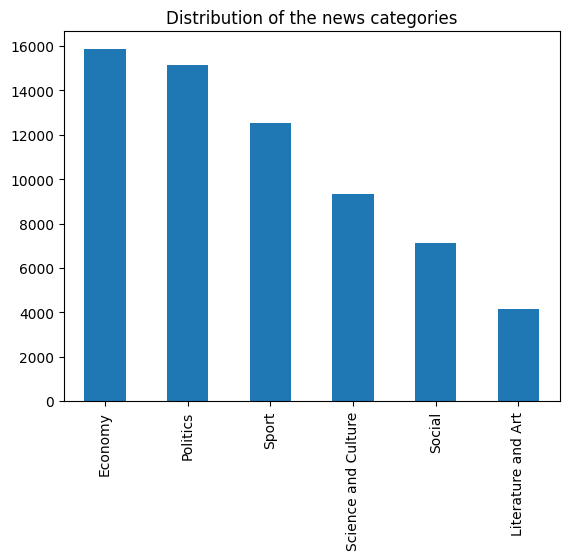

In [7]:
df['category'].value_counts().plot(kind='bar');
plt.title('Distribution of the news categories');

In [ ]:
df['text'][1]

'\nبا تصويب شوراي اقتصاداعتبارات طرحهاي \nعمراني انتفاعي با سود آنها از شركت هاي \nدولتي پس گرفته مي شود \nشوراي اقتصاد در جلسه روز دوشنبه اين هفته كه به رياست خاتمي \nرئيس جمهوري تشكيل شد، پيشنهاد مشترك سازمان برنامه و بودجه و وزارت \nامور اقتصادي و دارايي را درباره آئين نامه اصول، سياستها و ضوابط \nمربوط به اعطاي وام از محل اعتبارات طرحهاي عمراني انتفاعي به موسسات \nو شركت هاي دولتي و ساير موسسات در بخش عمومي و شهرداري ها بررسي و \nكليات آن را تصويب كرد. \nبه استناد ماده 32 قانون برنامه و بودجه وجوهي كه از محل اعتبارات \nعمراني براي اجراي طرحهاي عمراني انتفاعي به دستگاه هاي اجرايي مربوط \nپرداخت مي شود، به صورت وام خواهد بود. دستگاهي كه به اين ترتيب وام \nدريافت مي كند، مكلف است اصل و سود متعلقه را طبق قرارداد منعقده با \nوزارت امور اقتصادي و دارايي در سررسيدمقرر به خزانه بپردازد. \nهمچنين به استناد ماده 33 اين قانون در مورد برخي از طرحهاي \nعمراني انتفاعي كه توسط شركت هاي دولتي و موسسات وابسته به دولت اجرا \nشوراي مي شوند، اقتصاد مي تواند به پيشنهاد سازمان برنامه و بودجه \nاجازه حدا

In [12]:
tokenizer = hazm.word_tokenize

def common_words(category, n=10):
    category_data = df[df['category'] == category]
    text = ' '.join(category_data['text'])
    words = tokenizer(text)
    word_counts = Counter(words)
    commons = word_counts.most_common(n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=[count for word, count in commons], y=[word for word, count in commons])

    plt.title(f"Top 10 Words in {category}")
    plt.xlabel("Count")
    plt.ylabel("Words")
    plt.show()

In [14]:
df['category'].unique()

array(['Economy', 'Social', 'Politics', 'Science and Culture', 'Sport',
       'Literature and Art'], dtype=object)

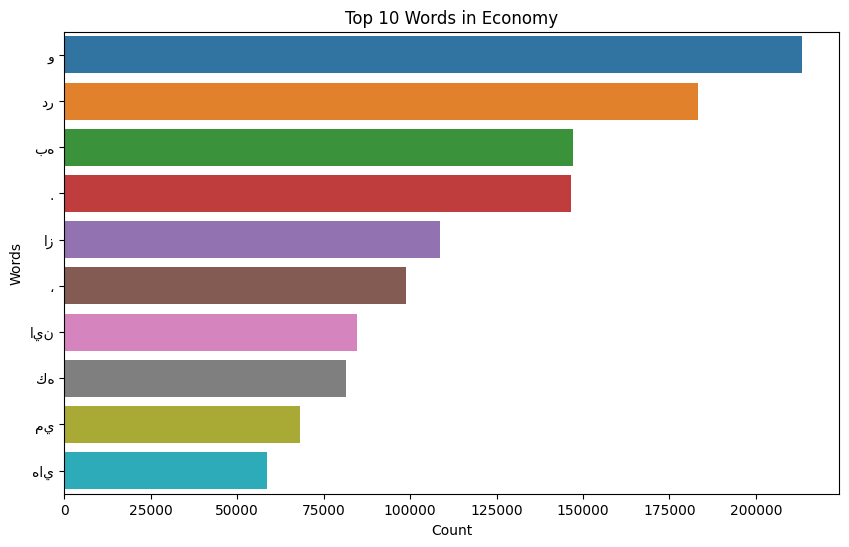

In [13]:
common_words('Economy')

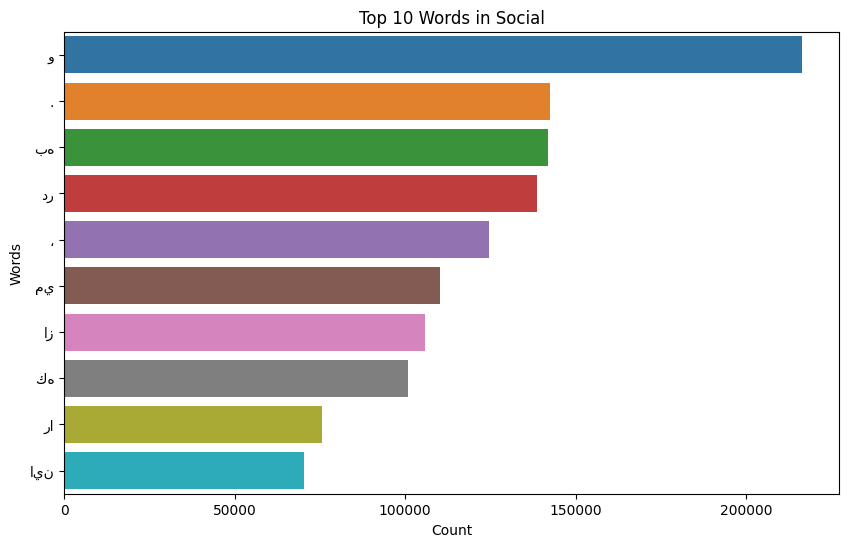

In [15]:
common_words('Social')

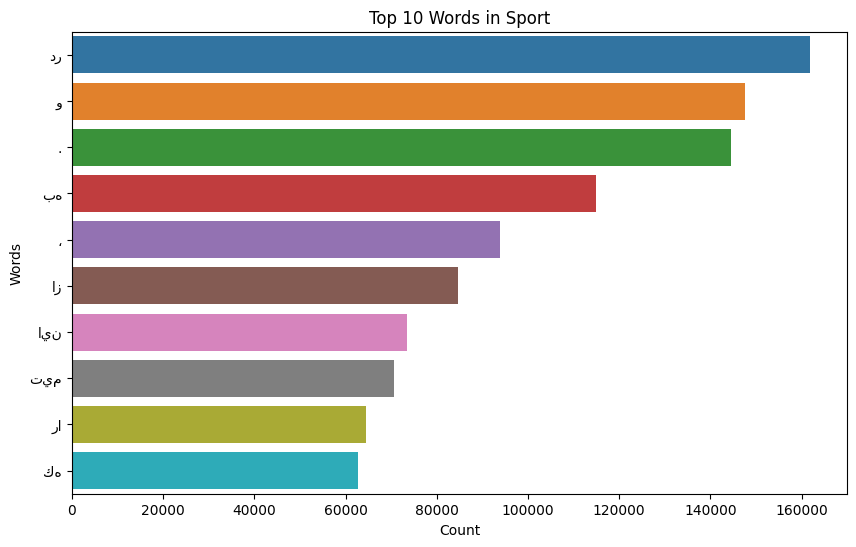

In [17]:
common_words('Sport')

# N-gram language models

In [44]:
class WordNgramClassifier:
    def __init__(self, train_path, save_path, n, norm=False):
        self.n = n
        self.ngram_models = {}
        self.train_path = train_path
        self.save_path = save_path
        self.norm = norm

    def _preprocess_text(self, data):
        if self.norm:
            normalizer = hazm.Normalizer()
            data['text'] = data['text'].apply(lambda text: normalizer.normalize(text))

        stopwords_list = hazm.stopwords_list()

        def remove_stopwords(text):
            tokens = hazm.word_tokenize(text)
            filtered_tokens = [token for token in tokens if token not in stopwords_list]
            return ' '.join(filtered_tokens)

        data['text'] = data['text'].apply(remove_stopwords)
        print(f'{datetime.datetime.now()} INFO - train dataset is pre-processed.')
        return data

    def _load_data(self):
        train_data = pd.read_csv(self.train_path)
        train_data.rename(columns={'CAT[2]/text()': 'category',
                        'TEXT[1]/text()': 'text', 'Unnamed: 0': 'id'}, inplace=True)

        print(f'{datetime.datetime.now()} INFO - train dataset is loaded.')

        train_data = self._preprocess_text(train_data)

        class_data = {}
        for class_label in train_data['category'].unique():
            class_data[class_label] = {
                'train': train_data[train_data['category'] == class_label]['text'].tolist(),
            }

        return class_data

    def _train_ngram_model(self, class_text):
        tokens = hazm.word_tokenize(class_text)
        n_grams = list(ngrams(tokens, self.n))
        ngram_freq = Counter(n_grams)
        total_ngrams = len(n_grams)

        alpha = 0.1  # smoothing parameter

        ngram_probabilities = {}
        for ngram in ngram_freq:
            count = ngram_freq[ngram]
            smoothed_prob = (count + alpha) / (total_ngrams + (alpha * len(ngram_freq)))
            ngram_probabilities[ngram] = smoothed_prob

        return ngram_probabilities

    def _train(self, class_data):
        print(f'{datetime.datetime.now()} INFO - training is started.')

        for class_label, data in tqdm(class_data.items(), desc='Training Model'):
            gc.collect()
            train_texts = data['train']
            class_model = {}
            for text in train_texts:
                class_model.update(self._train_ngram_model(text))

            self.ngram_models[class_label] = class_model

        print(f'\n{datetime.datetime.now()} INFO - training is done.')
        return self.ngram_models

    def _calculate_perplexity(self, text, ngram_model):
        tokens = hazm.word_tokenize(text)
        n_grams = list(ngrams(tokens, self.n))

        if len(n_grams) == 0:
            return float('inf')

        log_prob_sum = sum(-math.log(ngram_model.get(ngram, 1e-10)) for ngram in n_grams)
        perplexity = math.exp(log_prob_sum / len(n_grams))
        return perplexity

    def classify_text(self, test_text):
        perplexities = {}

        for class_label, ngram_model in self.ngram_models.items():
            perplexity = self._calculate_perplexity(test_text, ngram_model)
            perplexities[class_label] = perplexity

        min_perplexity_category = min(perplexities, key=perplexities.get)
        return min_perplexity_category

    def _save_models(self):
        try:
            os.mkdir(self.save_path)
        except OSError:
            pass

        models_to_save = {
            'ngram_models': self.ngram_models,
        }
        with open(self.save_path+f'/{self.n}_classifier_model_word.pkl', 'wb') as file:
            pickle.dump(models_to_save, file)

    def load_models(self):
        with open(self.save_path+f'/{self.n}_classifier_model_word.pkl', 'rb') as file:
            models = pickle.load(file)
            self.ngram_models = models['ngram_models']

        print(f'\n{datetime.datetime.now()} INFO - models are loaded.')

    def run(self):
        class_data = self._load_data()
        self._train(class_data)
        self._save_models()
        del class_data
        gc.collect()

In [23]:
def evaluate(classifier, test_path):
    test_data = pd.read_csv(test_path)
    test_data.rename(columns={'CAT[2]/text()': 'category',
                    'TEXT[1]/text()': 'text', 'Unnamed: 0': 'id'}, inplace=True)

    class_data = {}
    for class_label in test_data['category'].unique():
        class_data[class_label] = {
            'test': test_data[test_data['category'] == class_label]['text'].sample(frac=0.2).tolist()
        }

    true_labels = []
    predicted_labels = []

    for class_label, data in tqdm(class_data.items(), desc='Evaluate Models'):
        test_texts = data['test']
        for test_text in test_texts:
            predicted_class = classifier.classify_text(test_text)
            true_labels.append(class_label)
            predicted_labels.append(predicted_class)

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")

    label_encoder = LabelEncoder()
    true_labels_encoded = label_encoder.fit_transform(true_labels)
    predicted_labels_encoded = label_encoder.transform(predicted_labels)
    class_names = label_encoder.classes_

    del test_data
    gc.collect()

    cm = confusion_matrix(true_labels_encoded, predicted_labels_encoded)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Unigram model - word level

In [45]:
unigram_word = WordNgramClassifier(train_path='/content/hamshahri_dataset/train.csv', save_path='/content/models', n=1)
unigram_word.run()

2023-09-17 14:27:40.025622 INFO - train dataset is loaded.
2023-09-17 14:31:35.263917 INFO - train dataset is pre-processed.
2023-09-17 14:31:35.341343 INFO - training is started.


Training Model: 100%|██████████| 6/6 [00:49<00:00,  8.32s/it]



2023-09-17 14:32:25.290503 INFO - training is done.


In [ ]:
# If you ever wants to load these models!!!
unigram_word = WordNgramClassifier(train_path='/content/hamshahri_dataset/train.csv', save_path='/content/models', n=1)
unigram_word.load_models()

Evaluate Models: 100%|██████████| 6/6 [00:17<00:00,  2.97s/it]


Accuracy: 0.6793512164691204
Precision: 0.7051093322695413
Recall: 0.6793512164691204
F1-score: 0.6525815297513813


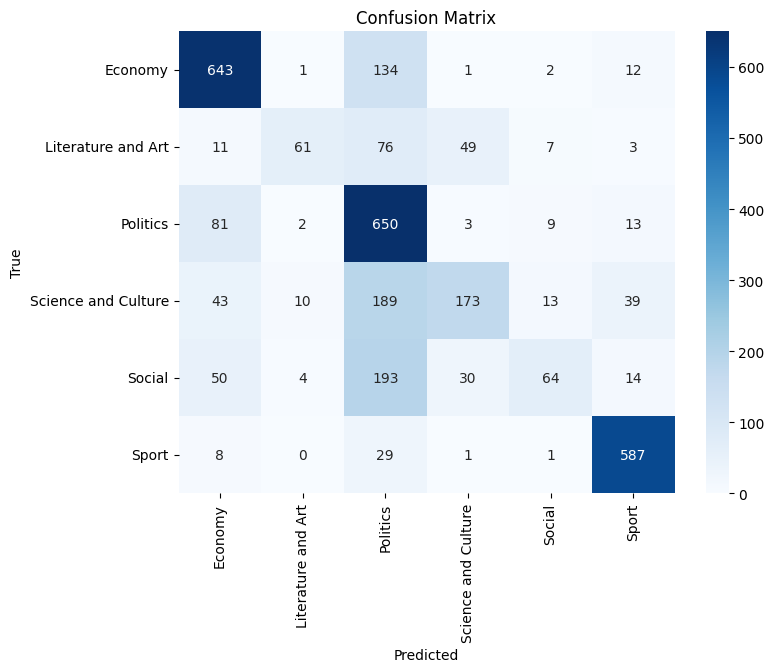

In [46]:
# after unseen n-grams
evaluate(unigram_word, test_path='/content/hamshahri_dataset/test.csv')

Evaluate Models: 100%|██████████| 6/6 [00:20<00:00,  3.48s/it]


Accuracy: 0.6971303805364941
Precision: 0.7226262390006858
Recall: 0.6971303805364941
F1-score: 0.6724721741123042


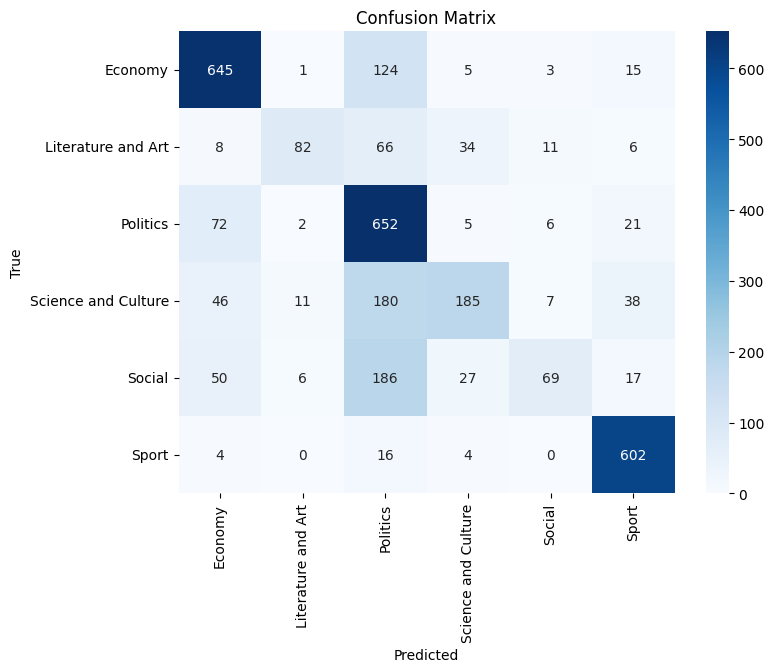

In [28]:
# after deleting stopwords
evaluate(unigram_word, test_path='/content/hamshahri_dataset/test.csv')

Evaluate Models: 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]


Accuracy: 0.6366188396756083
Precision: 0.7107434290608892
Recall: 0.6366188396756083
F1-score: 0.6118852791481407


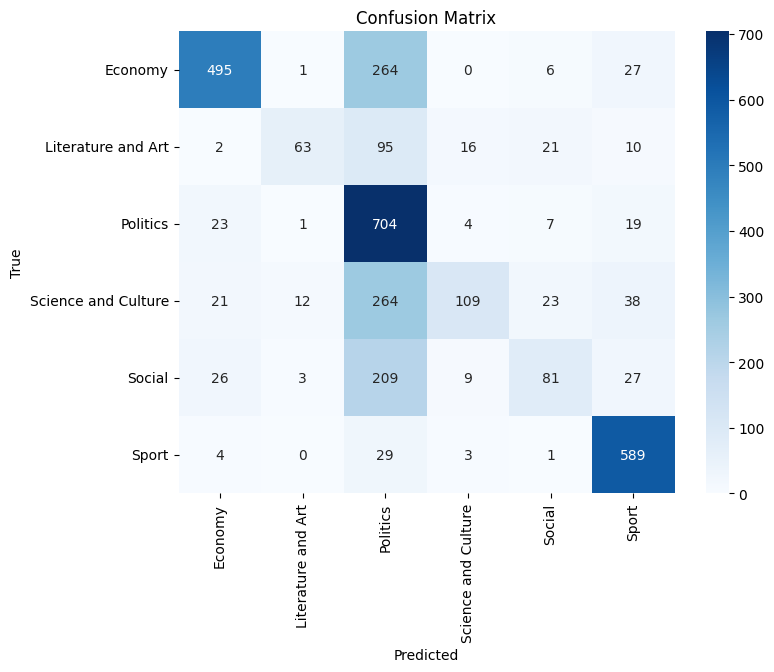

In [ ]:
# before deleting stopwords
evaluate(unigram_word, test_path='/content/hamshahri_dataset/test.csv')

# Bigram model - word level


In [47]:
bigram_word = WordNgramClassifier(train_path='/content/hamshahri_dataset/train.csv', save_path='/content/models', n=2)
bigram_word.run()

2023-09-17 14:32:51.359844 INFO - train dataset is loaded.
2023-09-17 14:36:38.402362 INFO - train dataset is pre-processed.
2023-09-17 14:36:38.475510 INFO - training is started.


Training Model: 100%|██████████| 6/6 [01:09<00:00, 11.52s/it]



2023-09-17 14:37:47.632994 INFO - training is done.


In [30]:
bigram_word = WordNgramClassifier(train_path='/content/hamshahri_dataset/train.csv', save_path='/content/models', n=2)
bigram_word.load_models()


2023-09-17 13:56:28.622753 INFO - models are loaded.


Evaluate Models: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]


Accuracy: 0.8705552089831566
Precision: 0.8745785462300126
Recall: 0.8705552089831566
F1-score: 0.868338673849424


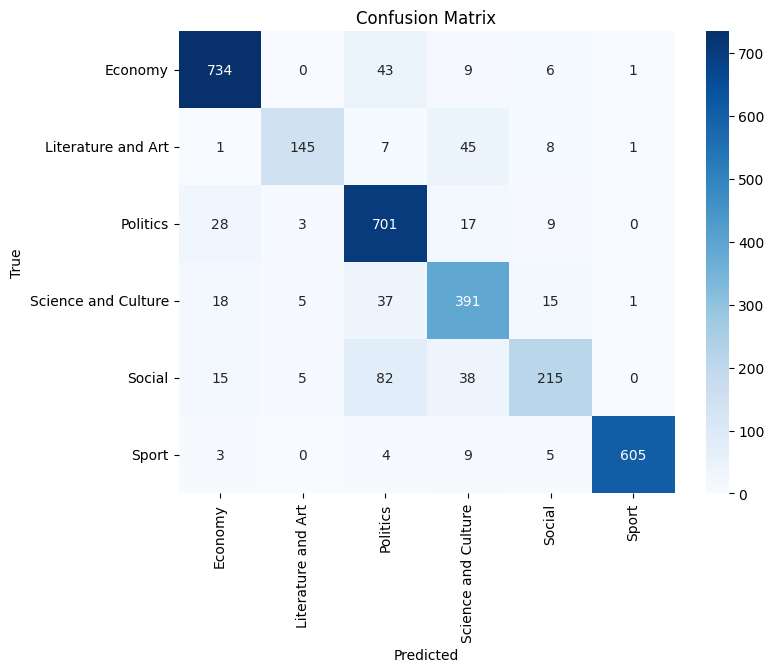

In [48]:
# after smoothing
evaluate(bigram_word, test_path='/content/hamshahri_dataset/test.csv')

Evaluate Models: 100%|██████████| 6/6 [00:19<00:00,  3.28s/it]


Accuracy: 0.8721147847785402
Precision: 0.8751187834522223
Recall: 0.8721147847785402
F1-score: 0.8696120224175651


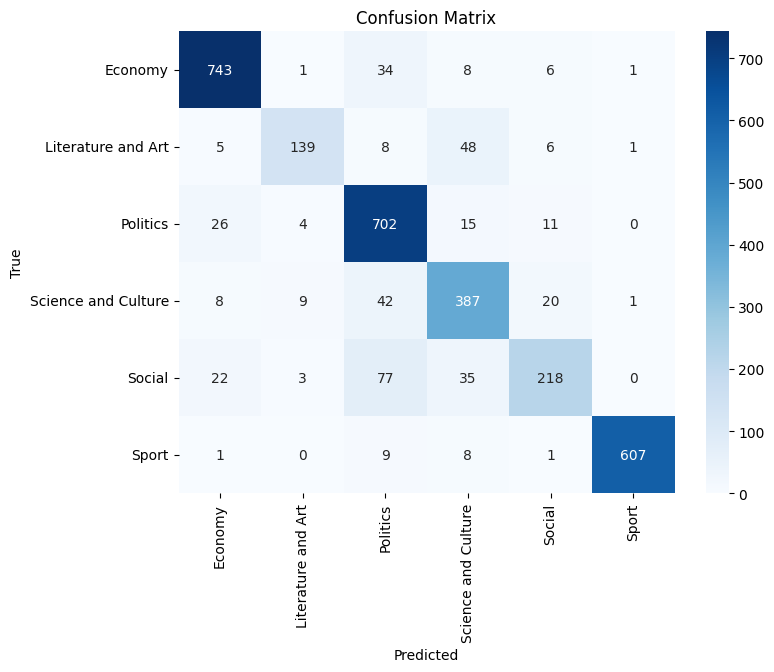

In [31]:
evaluate(bigram_word, test_path='/content/hamshahri_dataset/test.csv')

# N-gram language models - Character level

In [83]:
from itertools import tee
import string

class CharNgramClassifier:
    def __init__(self, train_path, save_path, n, norm=False):
        self.n = n
        self.ngram_models = {}
        self.train_path = train_path
        self.save_path = save_path
        self.norm = norm

    def _preprocess_text(self, data):
        normalizer = hazm.Normalizer()
        data['text'] = data['text'].apply(lambda text: normalizer.normalize(text))
        print(f'{datetime.datetime.now()} INFO - train dataset is normalized.')
        return data

    def _load_data(self):
        train_data = pd.read_csv(self.train_path)
        train_data.rename(columns={'CAT[2]/text()': 'category',
                        'TEXT[1]/text()': 'text', 'Unnamed: 0': 'id'}, inplace=True)

        print(f'{datetime.datetime.now()} INFO - train dataset is loaded.')

        if self.norm:
            train_data = self._preprocess_text(train_data)

        class_data = {}
        for class_label in train_data['category'].unique():
            class_data[class_label] = {
                'train': train_data[train_data['category'] == class_label]['text'].tolist(),
            }

        return class_data

    def _generate_ngrams(self, text):
        ngrams = []
        for i in range(len(text) - self.n + 1):
            ngram = text[i:i + self.n]

            # punctuation, digits and EN letters
            if all(char in string.punctuation or char.isspace() for char in ngram):
                continue
            if not any(char in string.ascii_letters + string.digits for char in ngram):
                    ngrams.append(ngram)

        return ngrams

    def _train_ngram_model(self, class_text):
        ngrams = self._generate_ngrams(class_text)
        ngram_freq = Counter(ngrams)
        total_ngrams = len(ngrams)

        vocabulary_size = len(set(ngrams))
        alpha = 0.1
        ngram_probabilities = {ngram: (count + alpha) / (total_ngrams + alpha * vocabulary_size) for ngram, count in ngram_freq.items()}

        stopwords = set(hazm.stopwords_list())
        ngram_probabilities = {ngram: prob for ngram, prob in ngram_probabilities.items() if ngram not in stopwords}

        return ngram_probabilities

    def _train(self, class_data):
        print(f'{datetime.datetime.now()} INFO - training is started.')

        for class_label, data in tqdm(class_data.items(), desc='Training Model'):
            train_texts = data['train']
            class_model = {}
            for text in train_texts:
                class_model.update(self._train_ngram_model(text))

            self.ngram_models[class_label] = class_model

        print(f'\n{datetime.datetime.now()} INFO - training is done.')
        return self.ngram_models

    def _calculate_perplexity(self, text, ngram_model):
        ngrams = self._generate_ngrams(text)

        if len(ngrams) == 0:
            return float('inf')

        log_prob_sum = sum(-math.log(ngram_model.get(ngram, 1e-10)) for ngram in ngrams)
        perplexity = math.exp(log_prob_sum / len(ngrams))
        return perplexity

    def classify_text(self, test_text):
        perplexities = {}

        for class_label, ngram_model in self.ngram_models.items():
            perplexity = self._calculate_perplexity(test_text, ngram_model)
            perplexities[class_label] = perplexity

        min_perplexity_category = min(perplexities, key=perplexities.get)
        return min_perplexity_category

    def _save_models(self):
        models_to_save = {
            'ngram_models': self.ngram_models,
        }
        with open(self.save_path+f'/{self.n}_classifier_model_char', 'wb') as file:
            pickle.dump(models_to_save, file)

    def load_models(self):
        with open(self.save_path+f'/{self.n}_classifier_model_char', 'rb') as file:
            models = pickle.load(file)
            self.ngram_models = models['ngram_models']

        print(f'\n{datetime.datetime.now()} INFO - models are loaded.')

    def run(self):
        class_data = self._load_data()
        self._train(class_data)
        self._save_models()
        del class_data
        gc.collect()

## Unigram - character level


In [84]:
unigram_char = CharNgramClassifier(train_path='/content/hamshahri_dataset/train.csv', save_path='/content/models', n=1)
unigram_char.run()

2023-09-17 16:39:37.306974 INFO - train dataset is loaded.
2023-09-17 16:39:37.395212 INFO - training is started.


Training Model: 100%|██████████| 6/6 [04:35<00:00, 45.95s/it]


2023-09-17 16:44:13.123646 INFO - training is done.


In [ ]:
unigram_char = CharNgramClassifier(train_path='/content/hamshahri_dataset/train.csv', save_path='/content/models', n=1)
unigram_char.load_models()


2023-09-15 15:02:30.814451 INFO - models are loaded.


Evaluate Models: 100%|██████████| 6/6 [01:16<00:00, 12.83s/it]


Accuracy: 0.2264504054897068
Precision: 0.28495380483681687
Recall: 0.2264504054897068
F1-score: 0.13711519630091715


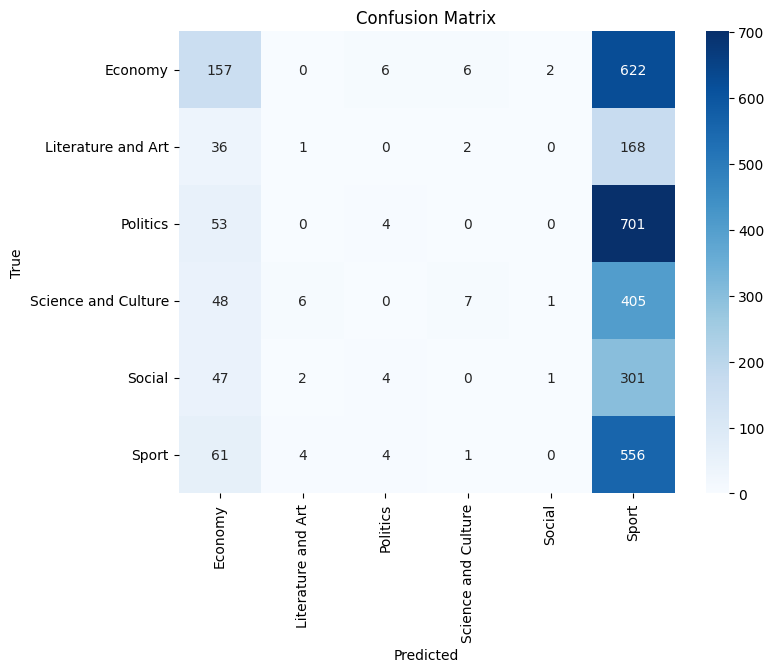

In [65]:
evaluate(unigram_char, test_path='/content/hamshahri_dataset/test.csv')

## Bigram - character level

In [ ]:
bigram_char = CharNgramClassifier(train_path='/content/hamshahri_dataset/train.csv', save_path='/content/models', n=2)
bigram_char.run()

In [ ]:
bigram_char = CharNgramClassifier(train_path='/content/hamshahri_dataset/train.csv', save_path='/content/models', n=2)
bigram_char.load_models()


2023-09-15 14:48:34.129706 INFO - models are loaded.


Evaluate Models: 100%|██████████| 6/6 [01:46<00:00, 17.78s/it]


Accuracy: 0.2043044291952589
Precision: 0.5042685418137695
Recall: 0.2043044291952589
F1-score: 0.08425841393662943


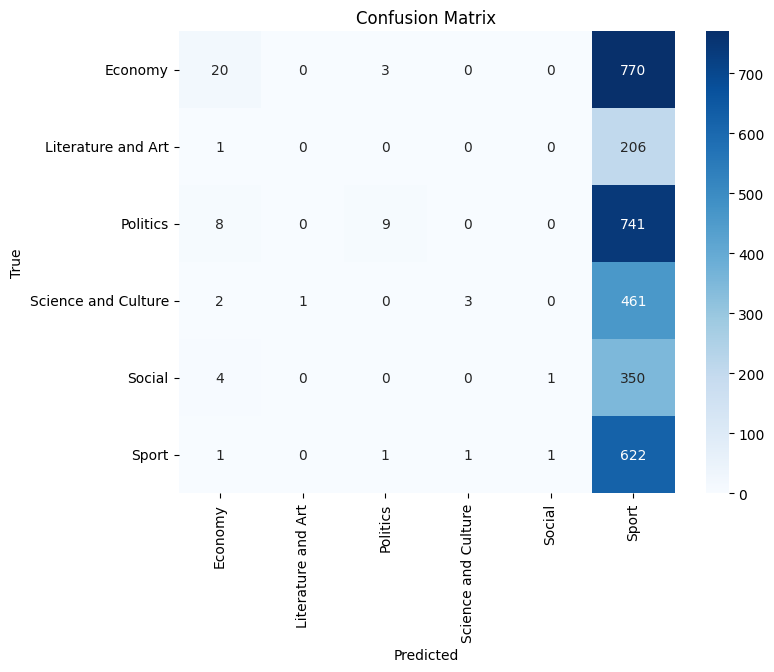

In [67]:
evaluate(bigram_char, test_path='/content/hamshahri_dataset/test.csv')